# ML Model for Virtual Regatta in order to determine boat angle

In this model, we will aggregate logs from all players to build the dataset

## Import required libraries

In [1]:
pip install smdebug

  Using cached smdebug-0.9.2-py2.py3-none-any.whl (173 kB)
ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/s3transfer-0.3.3.dist-info/METADATA'

Note: you may need to restart the kernel to use updated packages.


In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# update import path
import os, sys
from os.path import join

from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
import sagemaker
from sagemaker.estimator import Framework
from sagemaker.tensorflow import TensorFlow
from sagemaker import LocalSession
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, rule_configs

import matplotlib.pyplot as pyplot

import boto3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download Datasets from S3

In [34]:
def downloadDirectoryFroms3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucketName) 
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key)

In [36]:
data_bucket = 'virtual-regatta'
bucket = 'virtual-regatta-ml'
folder = 'logs_players/'

downloadDirectoryFroms3(s3_bucket, folder)

In [37]:
def aggregate_players_record(folder) :
    df_global = pd.DataFrame(columns=['datetime','boat_speed','boat_angle','wind_speed', 'angle_of_attack', 'lat', 'lon', 'target_angle'])
    for file in os.listdir(folder):
        df = pd.read_csv(join(folder, file))
        df_global = df_global.append(df, ignore_index=True)
    df_global.set_index('datetime')
    return df_global

In [38]:
data = aggregate_players_record(folder)

In [32]:
data.head()

,datetime,boat_speed,boat_angle,wind_speed,angle_of_attack,lat,lon,target_angle
0,2020-09-03 13:30:22,4.59649,170.8058,4.94541,123.33377,43.540166,9.288994,188.963459
1,2020-09-03 13:35:20,4.66457,170.8058,5.02156,122.93140,43.533812,9.290413,188.963459
2,2020-09-03 13:45:16,4.74133,170.8058,5.10141,123.31155,43.520986,9.293276,188.963459
3,2020-09-03 13:55:12,4.81348,170.8058,5.17579,123.74926,43.507961,9.296183,188.963459
4,2020-09-03 14:05:08,4.88091,170.8058,5.24458,124.24321,43.494741,9.299133,188.963459


In [31]:
print(data.shape)

(1865, 8)


In [39]:
data.describe()

,boat_speed,boat_angle,wind_speed,angle_of_attack,lat,lon,target_angle
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,6.675537,141.666766,11.106636,23.071084,45.737103,3.609135,176.072795
std,2.459648,45.008345,6.664975,112.989036,3.580484,7.968778,29.605890
min,1.787490,51.000000,3.687580,-177.061360,42.563000,-7.939762,8.959173
25%,4.691570,116.842600,5.415420,-91.203900,43.029039,-7.011000,175.717405
50%,5.891780,136.050940,7.642920,93.951010,43.252745,9.312061,187.569555
75%,9.814620,164.100980,20.047830,97.993230,50.527957,9.790852,188.963459
max,9.954010,328.000000,21.077130,162.784680,50.832882,10.139227,326.000000


## Data Vizualisation

Boat approaching the target course

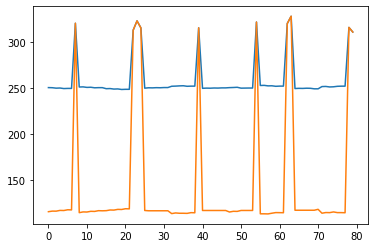

In [11]:
data['target_angle'][:2000].plot()
data['boat_angle'][:2000].plot()

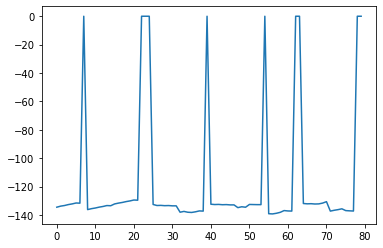

In [12]:
data['course_error'] = (data['boat_angle'] - data['target_angle'] + 180) % 360 -180
data['course_error'][:2000].plot()

In [13]:
data['course_error'].max()

0.0

In [14]:
corr = data.corr()
corr.style.background_gradient()

,boat_speed,boat_angle,wind_speed,angle_of_attack,lat,lon,target_angle,course_error
boat_speed,1.000000,0.215873,-0.203417,0.165166,-0.216444,0.217995,0.242779,0.201701
boat_angle,0.215873,1.000000,-0.998905,0.986994,-0.999423,0.999487,0.996491,0.999105
wind_speed,-0.203417,-0.998905,1.000000,-0.990559,0.998739,-0.998765,-0.995841,-0.997788
angle_of_attack,0.165166,0.986994,-0.990559,1.000000,-0.991016,0.990760,0.985536,0.985098
lat,-0.216444,-0.999423,0.998739,-0.991016,1.000000,-0.999944,-0.995841,-0.998567
lon,0.217995,0.999487,-0.998765,0.990760,-0.999944,1.000000,0.995947,0.998609
target_angle,0.242779,0.996491,-0.995841,0.985536,-0.995841,0.995947,1.000000,0.992059
course_error,0.201701,0.999105,-0.997788,0.985098,-0.998567,0.998609,0.992059,1.000000


### Save agreggated file

In [40]:
def saveAggregatedFile(data, bucket, prefix, filename) :
    csv_buffer = StringIO()
    data.to_csv(csv_buffer,header=True, index=False)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, prefix + '/data/input.csv').put(Body=csv_buffer.getvalue())

In [52]:
s3_prefix = 'navigation-boat-ml'    # prefix used for all data stored within the bucket

saveAggregatedFile(data, bucket, s3_prefix, 'input.csv')
print("Data saved")

Data saved


## Select Features and target

In [42]:
features = ['boat_speed', 'target_angle', 'angle_of_attack', 'wind_speed']

In [43]:
target = 'boat_angle'

The Python interpreter executes the user module, passing hyperparameters as script arguments.

In [44]:
hyperparameters = {'features': features, 
                   "target": target
                    #define the others hyperparameters set up in argumentParser of the train.py script if needed
                  }

In [51]:
s3_data_path = "s3://{}/{}/data/input.csv".format(bucket, s3_prefix)
print(s3_data_path)
s3_output_path = "s3://{}/{}/output".format(bucket, s3_prefix)
print(s3_output_path)

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker
print(role)

s3://virtual-regatta-ml/navigation-boat-ml/data/input.csv
s3://virtual-regatta-ml/navigation-boat-ml/output
arn:aws:iam::281633979087:role/service-role/AmazonSageMaker-ExecutionRole-20200828T144409


## Train locally

In [21]:
train_instance_type = 'local'

In [22]:
local_sgmk_session = LocalSession()

region = local_sgmk_session.boto_region_name

In [23]:
localEstimator = TensorFlow(
    role=role,
    base_job_name='boat-ml-keras',
    train_instance_count=1,
    train_instance_type=train_instance_type,
    entry_point='train.py',
    framework_version='2.2', # TensorFlow's version
    py_version='py37',
    output_path=s3_output_path,
    sagemaker_session=local_sgmk_session,
    source_dir='src'
)

localEstimator.fit()

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmpqza0fqwz_algo-1-47a8i_1 ... 
Attaching to tmpqza0fqwz_algo-1-47a8i_12mdone
algo-1-47a8i_1  | 2020-09-02 12:10:10,250 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-47a8i_1  | 2020-09-02 12:10:10,259 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-47a8i_1  | 2020-09-02 12:10:11,691 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
algo-1-47a8i_1  | /usr/local/bin/python3.7 -m pip install -r requirements.txt
algo-1-47a8i_1  | Collecting keras==2.4.3
algo-1-47a8i_1  |   Downloading Keras-2.4.3-py2.py3-none-any.whl (36 kB)
algo-1-47a8i_1  | Requirement already satisfied: numpy>=1.9.1 in /usr/local/lib/python3.7/site-packages (from keras==2.4.3->-r requirements.txt (line 1)) (1.19.1)
algo-1-47a8i_1  | Requirement already satisfied: scipy>=0.14 in /usr/local/lib/python3.7/site-packages (from keras==2.4.3->-r requirements.txt (line 1)) (1.4.1)
algo-1-47

2/2 [==============================] - 0s 61ms/step - loss: 0.2588 - mse: 0.2588 - val_loss: 0.0450 - val_mse: 0.0450
algo-1-47a8i_1  | Epoch 5/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0841 - mse: 0.0841 - val_loss: 0.0157 - val_mse: 0.0157
algo-1-47a8i_1  | Epoch 6/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.1104 - val_mse: 0.1104
algo-1-47a8i_1  | Epoch 7/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.1423 - val_mse: 0.1423
algo-1-47a8i_1  | Epoch 8/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1005 - mse: 0.1005 - val_loss: 0.0733 - val_mse: 0.0733
algo-1-47a8i_1  | Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0092 - val_mse: 0.0092
algo-1-47a8i_1  | Epoch 10/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0129 - val_mse: 

2/2 [==============================] - 0s 17ms/step - loss: 2.3465e-04 - mse: 2.3465e-04 - val_loss: 6.5374e-04 - val_mse: 6.5374e-04
algo-1-47a8i_1  | Epoch 59/100
2/2 [==============================] - 0s 17ms/step - loss: 2.7859e-04 - mse: 2.7859e-04 - val_loss: 6.7113e-04 - val_mse: 6.7113e-04
algo-1-47a8i_1  | Epoch 60/100
2/2 [==============================] - 0s 17ms/step - loss: 2.5074e-04 - mse: 2.5074e-04 - val_loss: 8.6278e-04 - val_mse: 8.6278e-04
algo-1-47a8i_1  | Epoch 61/100
2/2 [==============================] - 0s 20ms/step - loss: 1.8766e-04 - mse: 1.8766e-04 - val_loss: 0.0012 - val_mse: 0.0012
algo-1-47a8i_1  | Epoch 62/100
2/2 [==============================] - 0s 17ms/step - loss: 1.6032e-04 - mse: 1.6032e-04 - val_loss: 0.0014 - val_mse: 0.0014
algo-1-47a8i_1  | Epoch 63/100
2/2 [==============================] - 0s 16ms/step - loss: 1.8022e-04 - mse: 1.8022e-04 - val_loss: 0.0015 - val_mse: 0.0015
algo-1-47a8i_1  | Epoch 64/100
2/2 [=============================

## Train in SageMaker

In [53]:
sagemaker_session = sagemaker.Session()

train_instance_type="ml.m5.large"

estimator = TensorFlow(entry_point='train.py',
                       source_dir='src',
                       hyperparameters=hyperparameters,
                       role=role,
                       framework_version='1.15.2',
                       py_version='py3',
                       train_instance_count=1,
                       train_instance_type=train_instance_type,
                       base_job_name='boat-ml-keras')

estimator.fit()

ClientError: An error occurred (SignatureDoesNotMatch) when calling the GetCallerIdentity operation: Credential should be scoped to a valid region, not 'eu-west-2'. 

## Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [27]:
print(localEstimator)

localPredictor = localEstimator.deploy(
    initial_instance_count=1,
    instance_type='local')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


!

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py", line 618, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py", line 677, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py", line 623, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpho4h9_yc/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1



## Make predictions

Now we can use the predictor object to generate predictions.

In [ ]:
boat_speed = 6.9141
wind_speed = 14.2405
angle_of_attack = -139.8768
target_angle = 306.73887

payload = np.asarray([[boat_speed, wind_speed,angle_of_attack,target_angle]])
print(payload)

In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

payload_scaled = scaler_x.fit_transform(payload)
print(payload_scaled)

In [ ]:
response = localPredictor.predict(payload_scaled)

boat_angle = float(scaler_y.inverse_transform(response[0].reshape(1,-1)))
print(boat_angle) #return the predicted boat_angle

### Show performance

In [ ]:
data_dir = 'navigation-boat-ml/data/'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=s3_bucket, Key=data_dir+'x_test.csv')
x_test = pd.read_csv(obj['Body'])
print(x_test)

In [ ]:
obj = s3.get_object(Bucket=s3_bucket, Key=data_dir+'y_test.csv')
y_test = pd.read_csv(obj['Body'])
print(y_test)

In [ ]:
x_test_scaled = scaler_x.fit_transform(x_test)
print(x_test_scaled)

pred_y = model.predict(x_test_scaled)
pred_y_inversed = scaler_y.inverse_transform(pred_y)
print(f'Mean Absolute Error:{mean_absolute_error(pred_y_inversed, y_test)}')

## Delete endpoints

In [ ]:
localPredictor.delete_endpoint()